In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

### Data Extraction

In [3]:
weather_data = pd.read_csv("./Datasets/Weather Dataset - 84071567.csv",skiprows = 3)
solar_output = pd.read_excel(r"./Datasets/PV Plants Datasets.xlsx",sheet_name = '84071567')
metadata = pd.read_excel("./Datasets/PV Plants Metadata.xlsx")

In [4]:
weather_data.dropna(subset = ['temperature_2m (°C)','direct_radiation (W/m²)'], inplace=True)
weather_data.reset_index(drop = True,inplace=True)
weather_data.rename(columns={"time": "Date"},inplace=True)

In [5]:
solar_output['PV Serial Number'] = 84071567
weather_data['PV Serial Number'] = 84071567

In [6]:
# Merge the datasets
solar_output = pd.merge(solar_output, metadata, on='PV Serial Number', how='inner')

In [7]:
weather_data.rename(columns={'temperature_2m (°C)':'temperature','relative_humidity_2m (%)':'relative_humidity',
                            'rain (mm)':'rain','cloud_cover (%)':'cloud_cover','wind_speed_10m (km/h)':'wind_speed',
                            'shortwave_radiation (W/m²)':'shortwave_radiation','direct_radiation (W/m²)':'direct_radiation',
                            'diffuse_radiation (W/m²)':'diffuse_radiation'},inplace=True)

In [8]:
solar_output.rename(columns={'Produced Energy (kWh)':'Produced Energy','Specific Energy (kWh/kWp)':'Specific Energy',
                            'Installed Power (kWp)':'Installed Power','Connection Power (kWn)':'Connection Power'},inplace=True)

In [9]:
solar_output.head()

,Date,Produced Energy,Specific Energy,CO2 Avoided (tons),PV Serial Number,Location,Latitude,Longitude,From date,To date,Installed Power,Connection Power
0,2019-01-01 00:00:00,0.0,0.0,,84071567,Lisbon,38.728,-9.138,2019-01-01,2022-12-31,46.0,40.0
1,2019-01-01 01:00:00,0.0,0.0,,84071567,Lisbon,38.728,-9.138,2019-01-01,2022-12-31,46.0,40.0
2,2019-01-01 02:00:00,0.0,0.0,,84071567,Lisbon,38.728,-9.138,2019-01-01,2022-12-31,46.0,40.0
3,2019-01-01 03:00:00,0.0,0.0,,84071567,Lisbon,38.728,-9.138,2019-01-01,2022-12-31,46.0,40.0
4,2019-01-01 04:00:00,0.0,0.0,,84071567,Lisbon,38.728,-9.138,2019-01-01,2022-12-31,46.0,40.0


In [10]:
weather_data.head()

,Date,temperature,relative_humidity,rain,cloud_cover,wind_speed,shortwave_radiation,direct_radiation,diffuse_radiation,PV Serial Number
0,2021-03-23T01:00,12.2,54.0,0.0,7.0,3.0,0.0,0.0,0.0,84071567
1,2021-03-23T02:00,11.8,55.0,0.0,6.0,2.6,0.0,0.0,0.0,84071567
2,2021-03-23T03:00,11.5,56.0,0.0,6.0,2.3,0.0,0.0,0.0,84071567
3,2021-03-23T04:00,11.2,57.0,0.0,6.0,2.9,0.0,0.0,0.0,84071567
4,2021-03-23T05:00,10.9,57.0,0.0,5.0,3.3,0.0,0.0,0.0,84071567


### Data Preprocessing

In [11]:
solar_output['Date'] = pd.to_datetime(solar_output['Date'])
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
merged_data = pd.merge(solar_output, weather_data, on=['Date','PV Serial Number'], how='inner')

In [12]:
merged_data['Specific Energy'] = merged_data['Produced Energy'] / merged_data['Installed Power']

In [13]:
merged_data.drop(columns=['Location','Latitude','Longitude','Installed Power','Connection Power'],inplace=True)
merged_data.head()

,Date,Produced Energy,Specific Energy,CO2 Avoided (tons),PV Serial Number,From date,To date,temperature,relative_humidity,rain,cloud_cover,wind_speed,shortwave_radiation,direct_radiation,diffuse_radiation
0,2021-03-23 01:00:00,0.0,0.0,,84071567,2019-01-01,2022-12-31,12.2,54.0,0.0,7.0,3.0,0.0,0.0,0.0
1,2021-03-23 02:00:00,0.0,0.0,,84071567,2019-01-01,2022-12-31,11.8,55.0,0.0,6.0,2.6,0.0,0.0,0.0
2,2021-03-23 03:00:00,0.0,0.0,,84071567,2019-01-01,2022-12-31,11.5,56.0,0.0,6.0,2.3,0.0,0.0,0.0
3,2021-03-23 04:00:00,0.0,0.0,,84071567,2019-01-01,2022-12-31,11.2,57.0,0.0,6.0,2.9,0.0,0.0,0.0
4,2021-03-23 05:00:00,0.0,0.0,,84071567,2019-01-01,2022-12-31,10.9,57.0,0.0,5.0,3.3,0.0,0.0,0.0


### Exploratory Data Analysis (EDA)

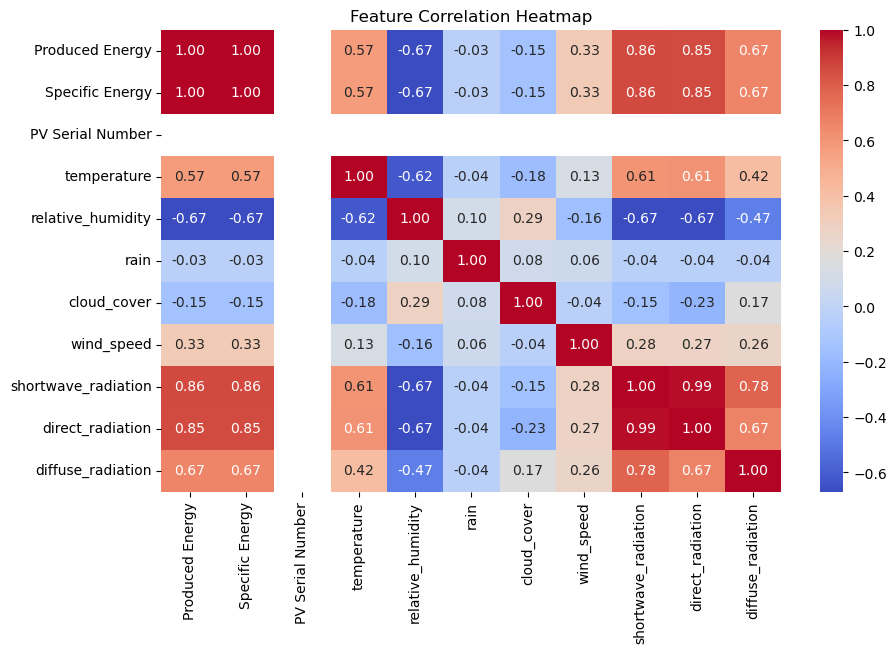

In [14]:
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

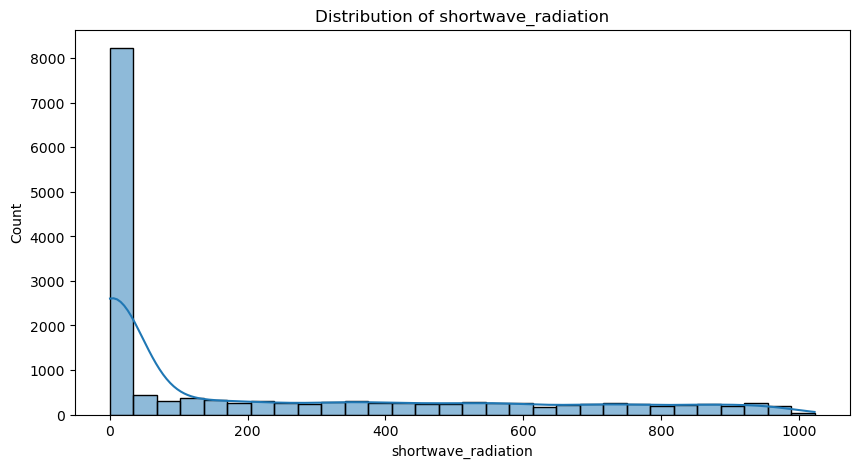

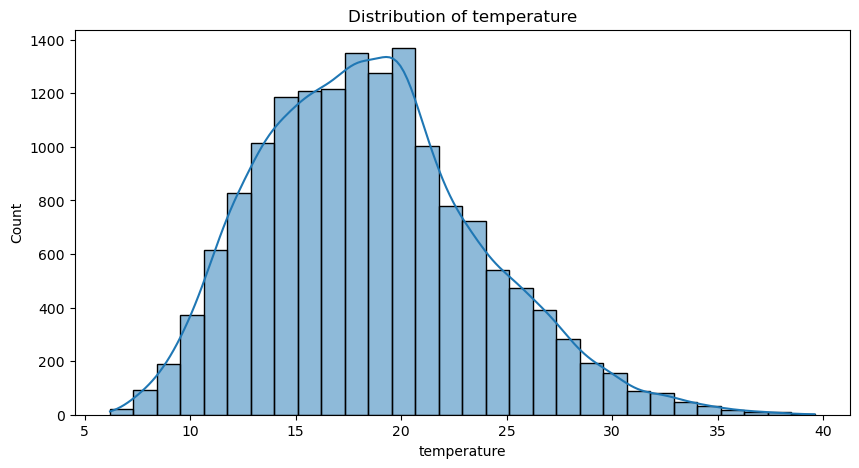

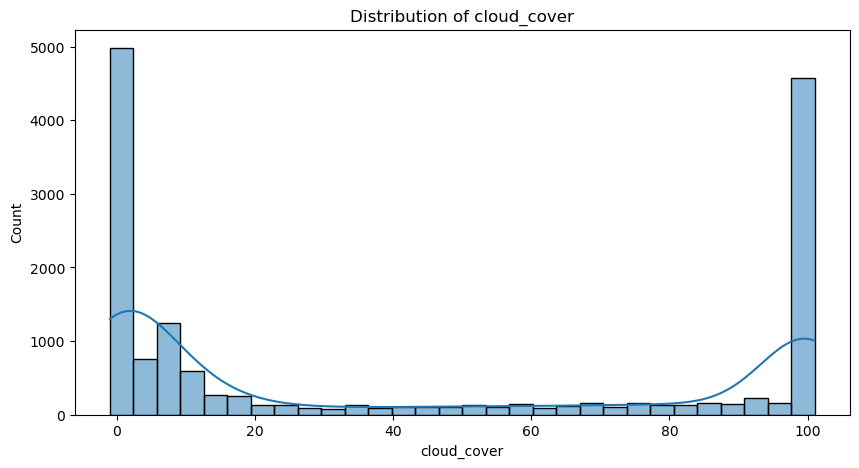

In [15]:
features = ['shortwave_radiation', 'temperature', 'cloud_cover']
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.histplot(merged_data[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.show()

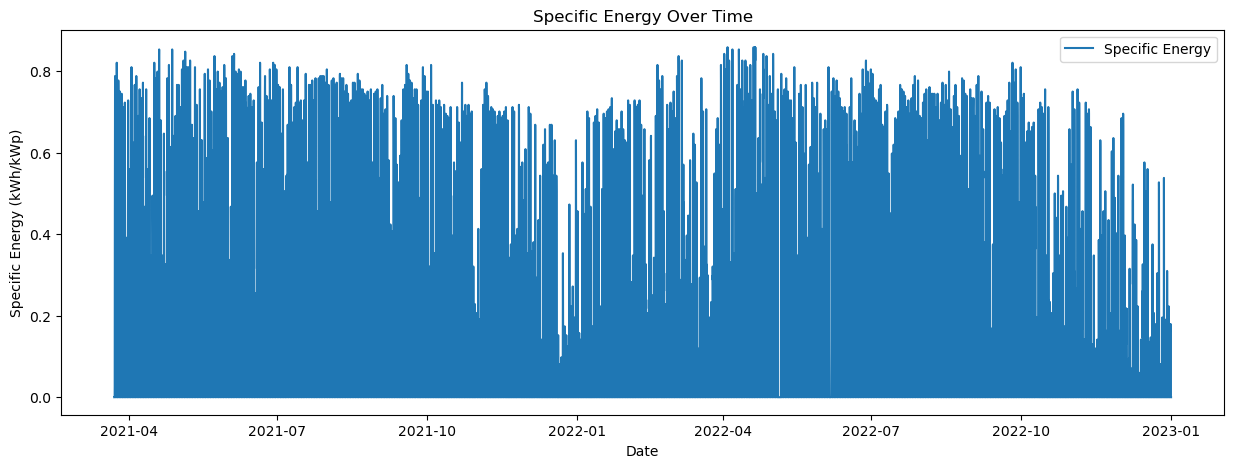

In [16]:
# Time series analysis
plt.figure(figsize=(15, 5))
plt.plot(merged_data['Date'], merged_data['Specific Energy'], label='Specific Energy')
plt.title("Specific Energy Over Time")
plt.xlabel("Date")
plt.ylabel("Specific Energy (kWh/kWp)")
plt.legend()
plt.show()

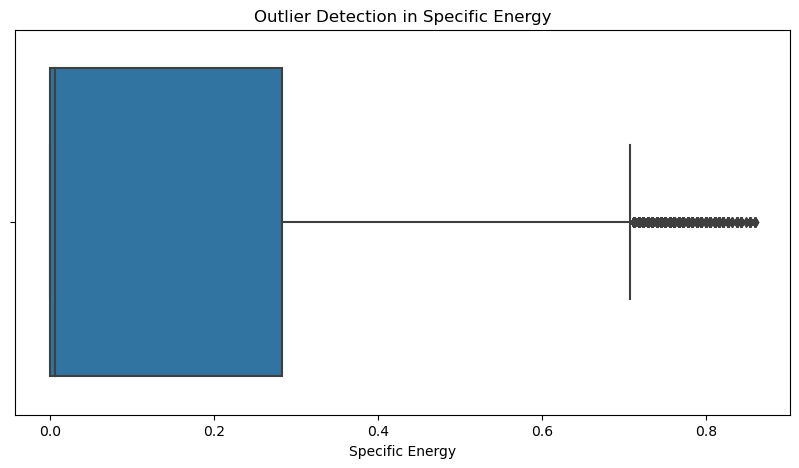

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=merged_data['Specific Energy'])
plt.title("Outlier Detection in Specific Energy")
plt.show()

### Feature Engineering

In [18]:
for lag in [1, 2, 3]:
    merged_data[f'Lag_{lag}_Radiation'] = merged_data['shortwave_radiation'].shift(lag)
merged_data['Cumulative Radiation'] = merged_data['shortwave_radiation'].cumsum()
merged_data['Rolling_Temp_Mean'] = merged_data['temperature'].rolling(window=3).mean()
merged_data['Radiation_CloudCover'] = merged_data['shortwave_radiation'] * merged_data['cloud_cover']
merged_data['Hour'] = merged_data['Date'].dt.hour
merged_data['DayOfWeek'] = merged_data['Date'].dt.dayofweek
merged_data = merged_data.dropna()

### Feature Selection

In [19]:
X = merged_data[['shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
                 'temperature', 'relative_humidity', 'cloud_cover',
                 'rain', 'wind_speed', 'Lag_1_Radiation', 'Lag_2_Radiation', 'Lag_3_Radiation',
                 'Cumulative Radiation', 'Rolling_Temp_Mean', 'Radiation_CloudCover',
                 'Hour', 'DayOfWeek']]
y = merged_data['Specific Energy']

In [20]:
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

Selected Features: ['shortwave_radiation', 'direct_radiation', 'diffuse_radiation', 'temperature', 'relative_humidity', 'Lag_1_Radiation', 'Lag_2_Radiation', 'Lag_3_Radiation', 'Rolling_Temp_Mean', 'Radiation_CloudCover']


### Model Building with Hyperparameter Tuning

In [21]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [22]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [23]:
param_grid = {
    "Random Forest": {'n_estimators': [50, 100, 200]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    "AdaBoost": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    "Support Vector Regressor": {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
}

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Support Vector Regressor": SVR()
}

In [24]:
results = {}
best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=3, scoring='r2')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
    
    preds = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results[name] = {'RMSE': rmse, 'R2 Score': r2}
    best_models[name] = best_model
    print(f"{name} - RMSE: {rmse}, R2: {r2}")

Linear Regression - RMSE: 0.09823632653219186, R2: 0.842088610964345
Ridge Regression - RMSE: 0.09823059549861884, R2: 0.8421070352907768
Lasso Regression - RMSE: 0.13872665357579728, R2: 0.6850881189781788
Random Forest - RMSE: 0.07585062750212786, R2: 0.9058570979564469
Gradient Boosting - RMSE: 0.0796273207650068, R2: 0.8962487274783821
AdaBoost - RMSE: 0.09574709200002424, R2: 0.8499899309739591
Support Vector Regressor - RMSE: 0.08407356263812416, R2: 0.8843386843766983


### Model Comparison

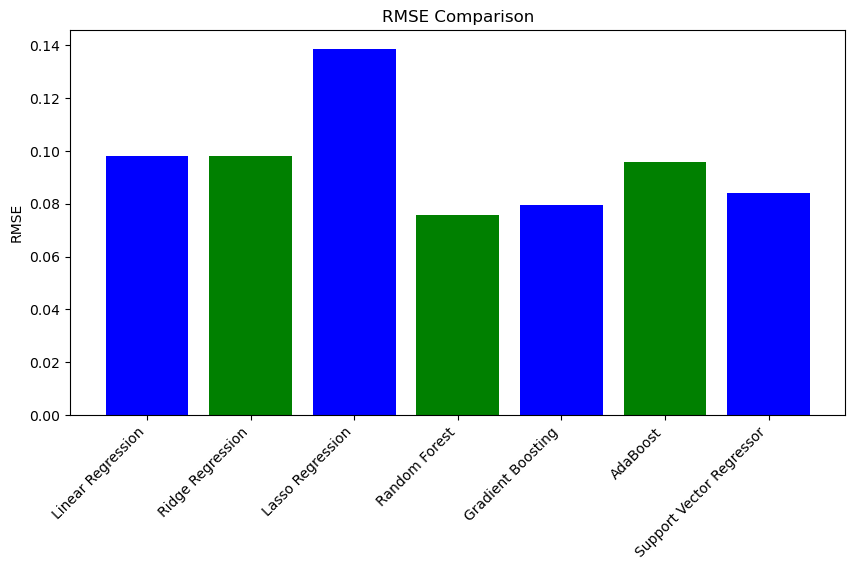

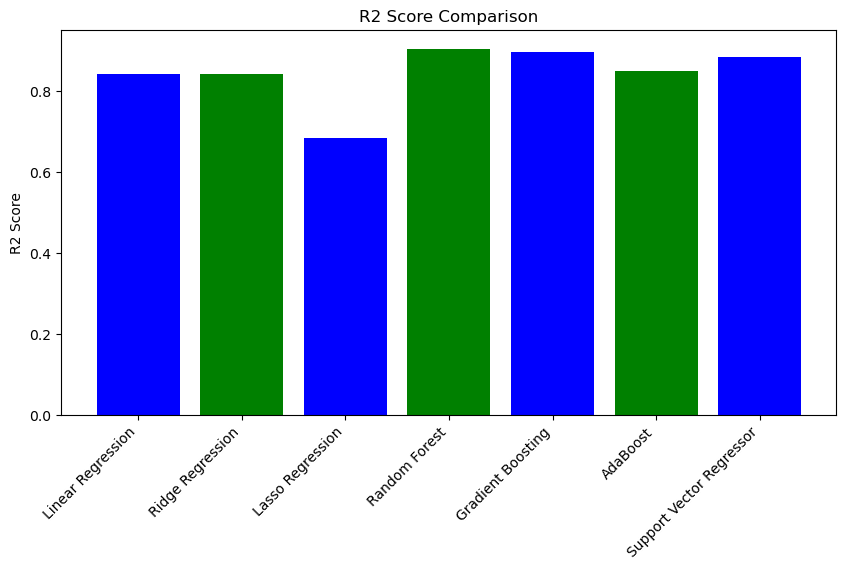

In [25]:
models_name = list(models.keys()) 
rmse_scores = []
r2_scores = []
for model,rmse in results.items():
    rmse_scores.append(results[model]['RMSE'])
    r2_scores.append(results[model]['R2 Score'])

plt.figure(figsize=(10, 5))
plt.bar(models_name, rmse_scores, color=['blue', 'green'])
plt.xticks(rotation=45, ha='right')
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(models_name, r2_scores, color=['blue', 'green'])
plt.xticks(rotation=45, ha='right')
plt.title("R2 Score Comparison")
plt.ylabel("R2 Score")
plt.show()

### Choosing the best model based on both R2 and RMSE

In [26]:
best_model_name = max(results, key=lambda k: (results[k]['R2 Score'], -results[k]['RMSE']))
best_model = best_models[best_model_name]

### Saving the model

In [27]:
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(selected_features, "features.pkl")
print(f"Best Model: {best_model_name} saved as best_model.pkl")

Best Model: Random Forest saved as best_model.pkl


### Real-time Prediction Function

In [28]:
def predict_energy(weather_data, metadata):
    model = joblib.load('best_model.pkl')
    selected_features = joblib.load("features.pkl")
    weather_data['latitude'] = metadata['latitude']
    weather_data['longitude'] = metadata['longitude']
    # Ensure proper transformation using selected features
    X_real_time = scaler.transform(weather_data[selected_features])
    X_real_time = pd.DataFrame(X_real_time, columns=selected_features)
    specific_energy = model.predict(X_real_time)
    total_energy = specific_energy * metadata['installed_power']
    return specific_energy, total_energy

In [29]:
arcotWeather = pd.read_csv(r'./Datasets/ArcotWeather_nov.csv',skiprows=3)
arcotWeather.rename(columns={'temperature_2m (°C)':'temperature','relative_humidity_2m (%)':'relative_humidity',
                            'rain (mm)':'rain','cloud_cover (%)':'cloud_cover','wind_speed_10m (km/h)':'wind_speed',
                            'shortwave_radiation (W/m²)':'shortwave_radiation','direct_radiation (W/m²)':'direct_radiation',
                            'diffuse_radiation (W/m²)':'diffuse_radiation'},inplace=True)
arcotWeather.reset_index(drop = True,inplace=True)
arcotWeather.rename(columns={"time": "Date"},inplace=True)
arcotWeather['Date'] = pd.to_datetime(arcotWeather['Date'])
arcotWeather['Hour'] = arcotWeather['Date'].dt.hour
arcotWeather['Month'] = arcotWeather['Date'].dt.month
arcotWeather['Date_only'] = arcotWeather['Date'].dt.date.astype(str)
arcotWeather['Hour_sin'] = np.sin(2 * np.pi * arcotWeather['Hour'] / 24)
arcotWeather['Hour_cos'] = np.cos(2 * np.pi * arcotWeather['Hour'] / 24)
arcotWeather['Month_cos'] = np.cos(2 * np.pi * arcotWeather['Month'] / 12)
for lag in [1, 2, 3]:
    arcotWeather[f'Lag_{lag}_Radiation'] = arcotWeather['shortwave_radiation'].shift(lag)
arcotWeather['Rolling_Temp_Mean'] = arcotWeather['temperature'].rolling(window=3).mean()
arcotWeather['Radiation_CloudCover'] = arcotWeather['shortwave_radiation'] * arcotWeather['cloud_cover']

In [30]:
result = (
    arcotWeather.groupby('Date_only')
    .apply(lambda x: x.drop(columns=['Date', 'Date_only']).to_dict(orient='records'))
    .to_dict()
)

In [31]:
total_list = []
required_features = joblib.load("features.pkl").to_list()
for date, records in result.items():
    total_energy_total = 0
    for record in records:
        filtered_data = []
        filtered_data.append({key: record[key] for key in required_features})
        # Convert to DataFrame
        real_time_weather = pd.DataFrame(filtered_data).fillna(0)
        metadata = {'latitude': 28.7041, 'longitude': 77.1025, 'installed_power': 310.0}
        specific_energy, total_energy = predict_energy(real_time_weather, metadata)
        total_energy_total = total_energy_total + total_energy
    total = {'Date':date,'Total_Solar_Energy':total_energy_total[0]}
    print(total)
    total_list.append(total)
res_df = pd.DataFrame(total_list)    
res_df

{'Date': '2024-11-01', 'Total_Solar_Energy': 808.0385869565218}
{'Date': '2024-11-02', 'Total_Solar_Energy': 804.3741847826087}
{'Date': '2024-11-03', 'Total_Solar_Energy': 819.0907608695654}
{'Date': '2024-11-04', 'Total_Solar_Energy': 899.8760869565217}
{'Date': '2024-11-05', 'Total_Solar_Energy': 1170.6711956521738}
{'Date': '2024-11-06', 'Total_Solar_Energy': 948.1114130434783}
{'Date': '2024-11-07', 'Total_Solar_Energy': 857.1921195652175}
{'Date': '2024-11-08', 'Total_Solar_Energy': 939.9486413043477}
{'Date': '2024-11-09', 'Total_Solar_Energy': 1003.127989130435}
{'Date': '2024-11-10', 'Total_Solar_Energy': 1062.6934782608694}
{'Date': '2024-11-11', 'Total_Solar_Energy': 1051.1274456521742}
{'Date': '2024-11-12', 'Total_Solar_Energy': 586.1527173913046}
{'Date': '2024-11-13', 'Total_Solar_Energy': 497.0361413043476}
{'Date': '2024-11-14', 'Total_Solar_Energy': 620.3453804347828}
{'Date': '2024-11-15', 'Total_Solar_Energy': 724.7345108695653}
{'Date': '2024-11-16', 'Total_Solar_E

,Date,Total_Solar_Energy
0,2024-11-01,808.038587
1,2024-11-02,804.374185
2,2024-11-03,819.090761
3,2024-11-04,899.876087
4,2024-11-05,1170.671196
5,2024-11-06,948.111413
6,2024-11-07,857.192120
7,2024-11-08,939.948641
8,2024-11-09,1003.127989
9,2024-11-10,1062.693478
